In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
import matplotlib.pyplot as plt
import os

# Hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 224  
CHANNELS = 3
EPOCHS = 10  # Increased epochs for better training


In [2]:
# Load and preprocess the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r".\potato leaf dataset",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Class names
class_names = dataset.class_names
print("Classes:", class_names)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 23458 files belonging to 2 classes.
Classes: ['non_potato_leaf', 'potato_leaf']


In [3]:
# Build the model using EfficientNetB3 for better accuracy
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
base_model.trainable = False  # Freeze base model layers

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Multi-class classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,177,521 (42.64 MB)

 Trainable params: 393,986 (1.50 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [4]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/10
587/587 ━━━━━━━━━━━━━━━━━━━━ 664s 1s/step - accuracy: 0.9657 - loss: 0.0784 - val_accuracy: 0.9970 - val_loss: 0.0096
Epoch 2/10
587/587 ━━━━━━━━━━━━━━━━━━━━ 492s 839ms/step - accuracy: 0.9914 - loss: 0.0247 - val_accuracy: 0.9974 - val_loss: 0.0095
Epoch 3/10
587/587 ━━━━━━━━━━━━━━━━━━━━ 586s 998ms/step - accuracy: 0.9941 - loss: 0.0194 - val_accuracy: 0.9944 - val_loss: 0.0129
Epoch 4/10
587/587 ━━━━━━━━━━━━━━━━━━━━ 427s 727ms/step - accuracy: 0.9940 - loss: 0.0198 - val_accuracy: 0.9979 - val_loss: 0.0073
Epoch 5/10
587/587 ━━━━━━━━━━━━━━━━━━━━ 373s 636ms/step - accuracy: 0.9954 - loss: 0.0132 - val_accuracy: 0.9974 - val_loss: 0.0059
Epoch 6/10
587/587 ━━━━━━━━━━━━━━━━━━━━ 370s 631ms/step - accuracy: 0.9965 - loss: 0.0112 - val_accuracy: 0.9979 - val_loss: 0.0067
Epoch 7/10
587/587 ━━━━━━━━━━━━━━━━━━━━ 368s 628ms/step - accuracy: 0.9959 - loss: 0.0137 - val_accuracy: 0.9987 - val_loss: 0.0047
Epoch 8/10
587/587 ━━━━━━━━━━━━━━━━━━━━ 373s 635ms/step - accuracy: 0.9954 - lo

In [1]:
effnet_test_loss, effnet_test_acc = model.evaluate(test_ds)
print(f"EfficientNetB0 Test Accuracy: {effnet_test_acc * 100:.2f}%")

NameError: name 'model' is not defined

In [5]:
# Unfreeze the top layers of the EfficientNetB3 model for fine-tuning
base_model.trainable = True

# Fine-tune from a specific layer
fine_tune_at = 100  # You can change this to a specific layer index to unfreeze only certain layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model after unfreezing the layers
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training for more epochs (fine-tuning)
history_fine_tune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,  # Fine-tuning for a few more epochs
    verbose=1
)


Epoch 1/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 1029s 2s/step - accuracy: 0.9444 - loss: 0.2016 - val_accuracy: 0.9974 - val_loss: 0.0091
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.9933 - loss: 0.0202 - val_accuracy: 0.9974 - val_loss: 0.0060
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 963s 2s/step - accuracy: 0.9968 - loss: 0.0104 - val_accuracy: 0.9979 - val_loss: 0.0043
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 923s 2s/step - accuracy: 0.9979 - loss: 0.0054 - val_accuracy: 0.9983 - val_loss: 0.0038
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.9985 - loss: 0.0041 - val_accuracy: 0.9979 - val_loss: 0.0043


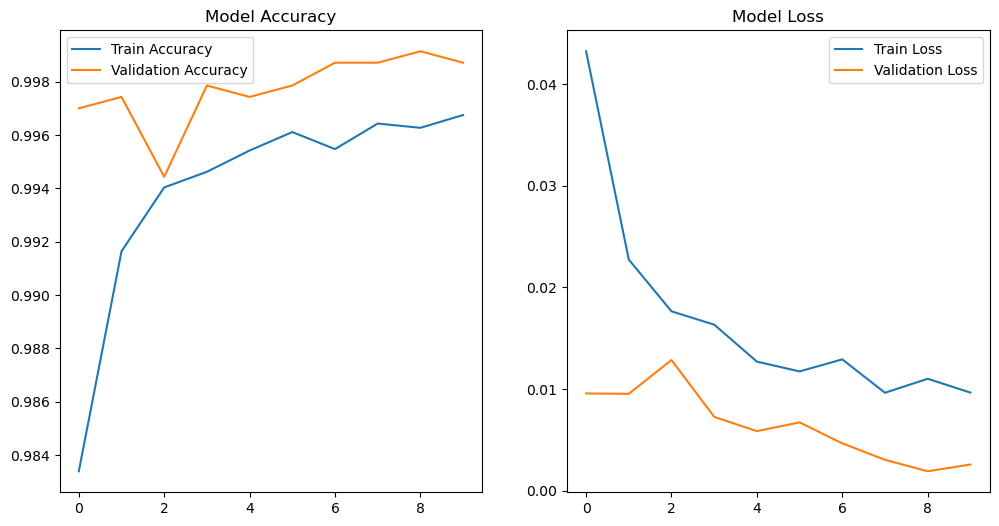

In [6]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.show()


In [7]:
# Save the trained model
model_save_path = r"C:\Users\ravimolake\Desktop\Tater-check\saved_models\potato_leaf_detector_v2.h5"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)
print(f"Model saved at '{model_save_path}'")


Model saved at 'C:\Users\ravimolake\Desktop\Tater-check\saved_models\potato_leaf_detector_v2.h5'
